In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)
words = get_unique_words(df)
tags = get_unique_tags(df)

num_words = len(words)
num_tags = len(tags)
max_len = 100

In [6]:
model = blstm_crf_model(num_words, num_tags, max_len)

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      1344500     ['inputs[0][0]']                 
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 50)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 200)     120800      ['spatial_dropout1d[0][0]

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
num_epoch = 50
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='max',
                                   baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
91/91 [==============================] - 22s 183ms/step - decode_sequence_acc: 0.3742 - loss: 17.7235 - val_decode_sequence_acc: 0.9683 - val_loss: 10.1619
Epoch 2/50
91/91 [==============================] - 14s 152ms/step - decode_sequence_acc: 0.9849 - loss: 4.0777 - val_decode_sequence_acc: 0.9717 - val_loss: 9.2761
Epoch 3/50
91/91 [==============================] - 13s 143ms/step - decode_sequence_acc: 0.9936 - loss: 1.7479 - val_decode_sequence_acc: 0.9725 - val_loss: 9.0454
Epoch 4/50
91/91 [==============================] - 13s 144ms/step - decode_sequence_acc: 0.9954 - loss: 1.1628 - val_decode_sequence_acc: 0.9742 - val_loss: 10.4380
Epoch 5/50
91/91 [==============================] - 13s 146ms/step - decode_sequence_acc: 0.9966 - loss: 0.8723 - val_decode_sequence_acc: 0.9741 - val_loss: 10.6590
Epoch 6/50
91/91 [==============================] - 14s 149ms/step - decode_sequence_acc: 0.9973 - loss: 0.6895 - val_decode_sequence_acc: 0.9732 - val_loss: 10.5325
Epoch

In [8]:
print(model.evaluate(X_test, y_test))
model.save('model/blstm_crf.h5')

56/56 [==============================] - 2s 28ms/step - decode_sequence_acc: 0.9741 - loss: 10.0603
[0.9741325378417969, 10.56932544708252]


In [9]:
# just check the oputput
a,b,c,d = model.predict(X_test)
print(b.shape)
y_pred = np.argmax(b, axis=-1)

(1781, 100, 7)


In [10]:
i = np.random.randint(0, X_test.shape[0]) #659
decode_seq, potentials, seq_length, kernel = model.predict(np.array([X_test[i]]))
p = np.argmax(potentials, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	JV
rek                           JV        	ID
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-JV
fillet                        EN        	ID
?                             O         	O
spill                         EN        	EN
dipasar                       ID        	ID
mana 

In [11]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    decode_seq, potentials, seq_length, kernel = model.predict(np.array([X_test[i]]))
    p = np.argmax(potentials, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	ID
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN   

In [12]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8851    0.9604    0.9212     22309
          JV     0.8906    0.7855    0.8348      4914
          EN     0.8932    0.8295    0.8602      5020
   MIX-ID-EN     0.9874    0.8047    0.8867       973
   MIX-ID-JV     0.9793    0.8429    0.9060       280
   MIX-JV-EN     0.8732    0.8700    0.8716       277
           O     0.9147    0.8480    0.8801     10151

    accuracy                         0.8951     43924
   macro avg     0.9176    0.8487    0.8801     43924
weighted avg     0.8963    0.8951    0.8939     43924



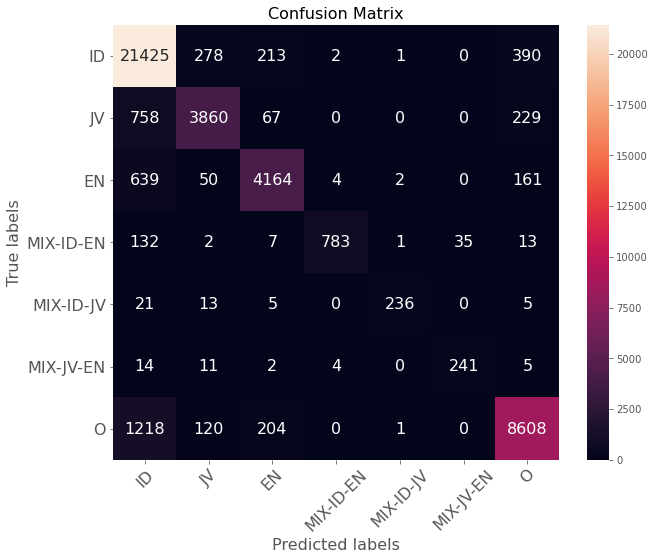

In [13]:
performance_report(true_flat, pred_flat)

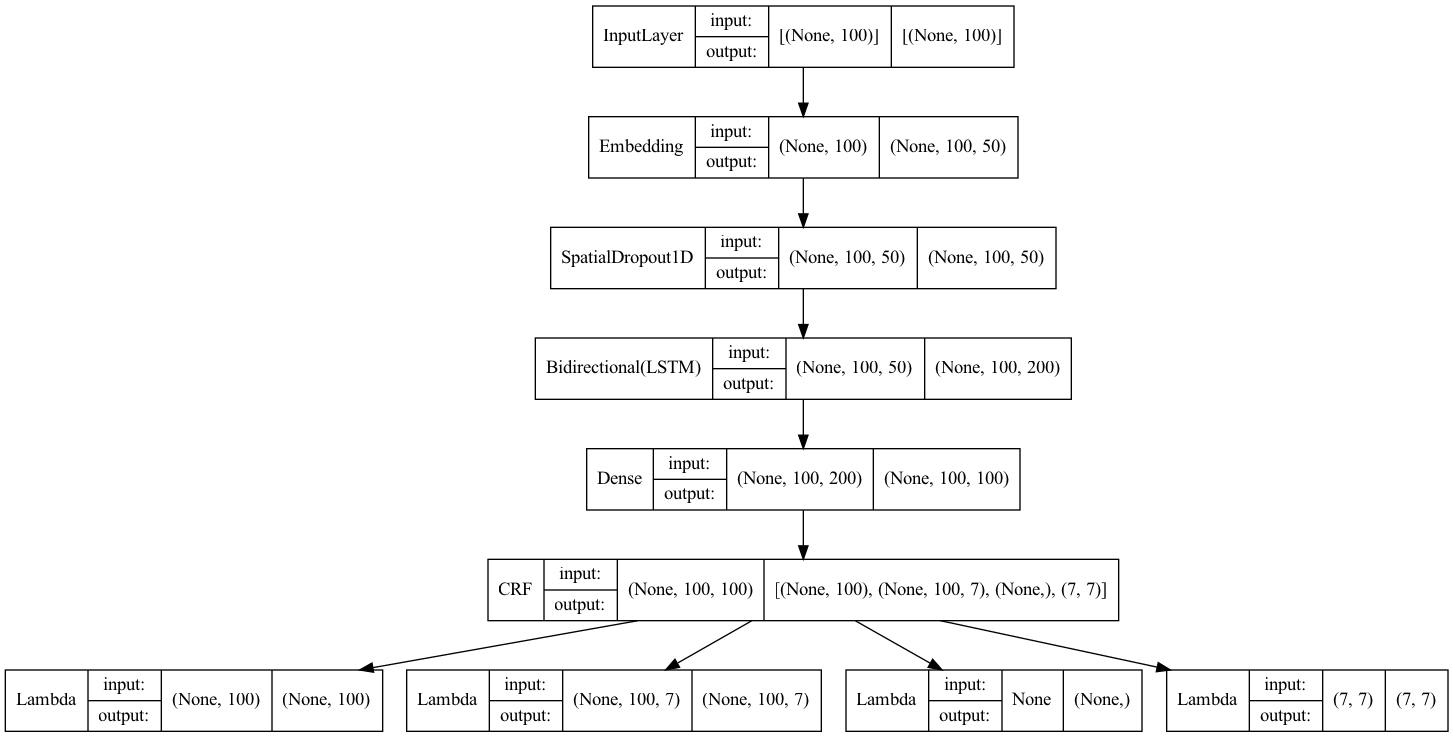

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_blstm_crf.png', show_shapes=True, show_layer_names=False)